# Inference: using saved pipeline

<a href="https://mybinder.org/v2/gh/tinkoff-ai/etna/master?filepath=examples/inference.ipynb">
    <img src="https://mybinder.org/badge_logo.svg"  align='left'>
</a>

This notebook contains the example of usage already fitted and saved pipeline on a new data.

**Table of Contents**

* [Preparing data](#chapter1)
* [Fitting pipeline](#chapter2)
* [Using saved pipeline on a new data](#chapter3)

In [1]:
import warnings

warnings.filterwarnings(action="ignore", message="Torchmetrics v0.9")
warnings.filterwarnings(action="ignore", message="`tsfresh` is not available")

In [2]:
import pathlib

HORIZON = 30
SAVE_DIR = pathlib.Path("tmp")
SAVE_DIR.mkdir(exist_ok=True)

## 1. Preparing data <a class="anchor" id="chapter1"></a>

In this section we load data and prepare if for our pipeline.

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv("data/example_dataset.csv")
df.head()

,timestamp,segment,target
0,2019-01-01,segment_a,170
1,2019-01-02,segment_a,243
2,2019-01-03,segment_a,267
3,2019-01-04,segment_a,287
4,2019-01-05,segment_a,279


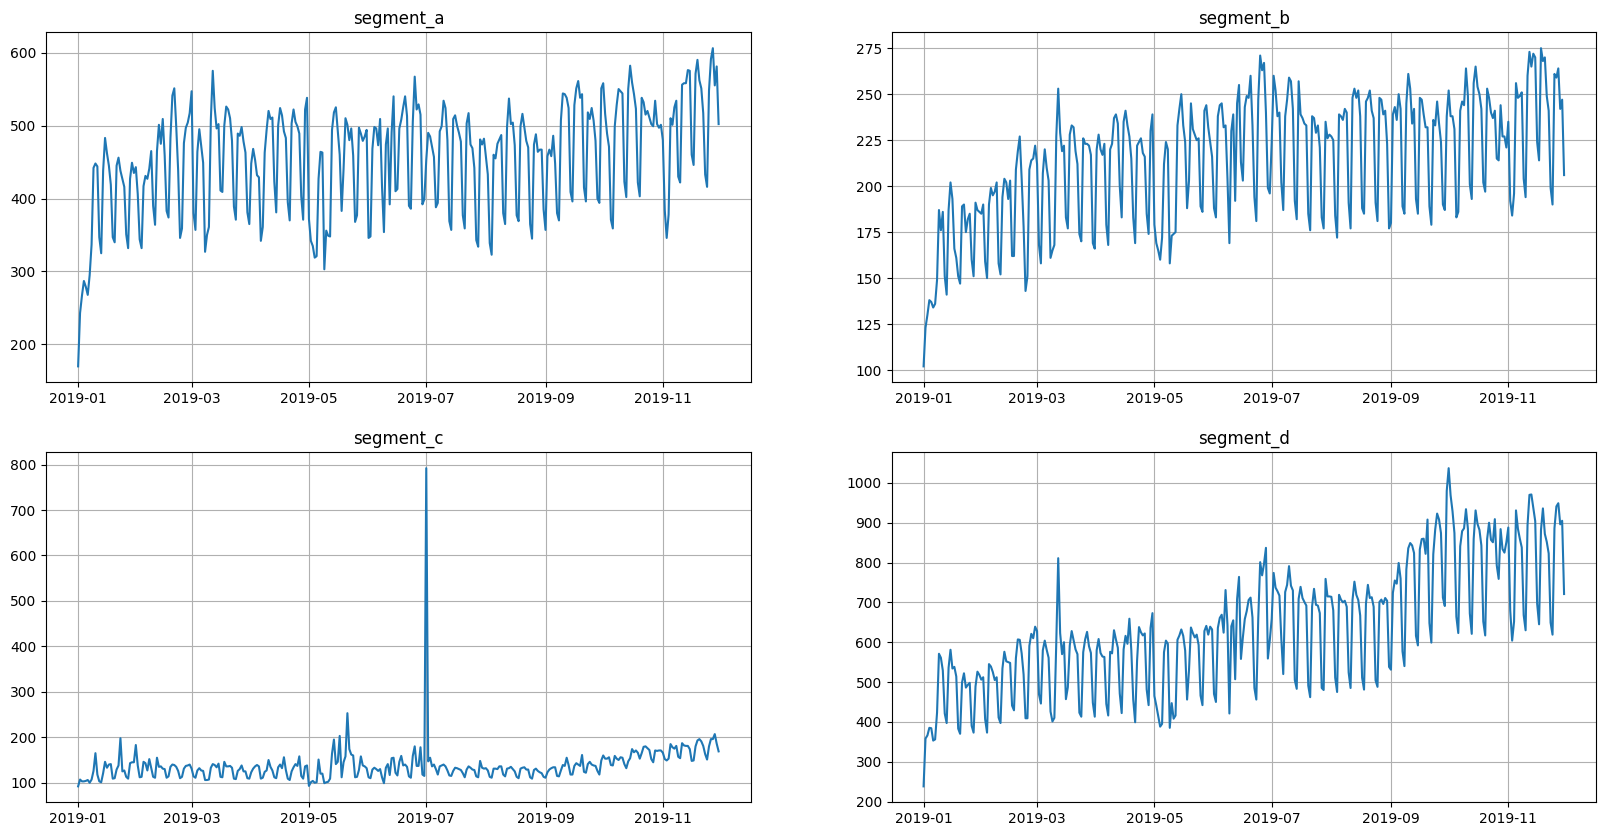

In [5]:
from etna.datasets import TSDataset

df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")
ts.plot()

Make two versions of data: old and new. New version includes more timestamps.

In [6]:
new_ts, test_ts = ts.train_test_split(test_size=HORIZON)
old_ts, _ = ts.train_test_split(test_size=HORIZON * 3)

## 2. Fitting pipeline <a class="anchor" id="chapter2"></a>

In this section we fit pipeline on `old_ts` and save to use in the future.

In [7]:
from etna.transforms import (
    MeanTransform,
    LagTransform,
    LogTransform,
    SegmentEncoderTransform,
    DateFlagsTransform,
    LinearTrendTransform,
)
from etna.pipeline import Pipeline
from etna.models.catboost import CatBoostMultiSegmentModel

log = LogTransform(in_column="target")
seg = SegmentEncoderTransform()
lags = LagTransform(in_column="target", lags=list(range(HORIZON, 96, 1)))
date_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    month_number_in_year=True,
)

model = CatBoostMultiSegmentModel()
transforms = [log, seg, lags, date_flags]
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)

In [8]:
pipeline.fit(old_ts)

Pipeline(model = CatBoostMultiSegmentModel(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], out_column = None, ), DateFlagsTransform(day_number_in_week = True, day_number_in_month = True, day_number_in_year = False, week_number_in_month = True, week_number_in_year = False, month_number_in_year = True, season_number = False, year_number = False, is_weekend = True, special_days_in_week = (), special_days_in_month = (), out_column = None, )], horizon = 30, )

Let's save ready pipeline on disk.

In [9]:
pipeline.save(SAVE_DIR / "pipeline.zip")

Currently, we can't save `TSDataset`. But model and transforms are successfully saved.

## 3. Using saved pipeline on a new data <a class="anchor" id="chapter3"></a>

In this section we load saved pipeline and apply it for prediction on `new_ts`.

In [10]:
from etna.core import load

del pipeline
pipeline = load(SAVE_DIR / "pipeline.zip", ts=new_ts)
pipeline

Pipeline(model = CatBoostMultiSegmentModel(iterations = None, depth = None, learning_rate = None, logging_level = 'Silent', l2_leaf_reg = None, thread_count = None, ), transforms = [LogTransform(in_column = 'target', base = 10, inplace = True, out_column = None, ), SegmentEncoderTransform(), LagTransform(in_column = 'target', lags = [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95], out_column = None, ), DateFlagsTransform(day_number_in_week = True, day_number_in_month = True, day_number_in_year = False, week_number_in_month = True, week_number_in_year = False, month_number_in_year = True, season_number = False, year_number = False, is_weekend = True, special_days_in_week = (), special_days_in_month = (), out_column = None, )], horizon = 30, )

Here we explicitly set `ts=new_ts` in `load` function in order to pass it inside our `pipeline`. Otherwise, `pipeline` doesn't have any `ts` to work with.

Use this pipeline for prediction.

In [11]:
forecast_ts = pipeline.forecast()

Look at predictions.

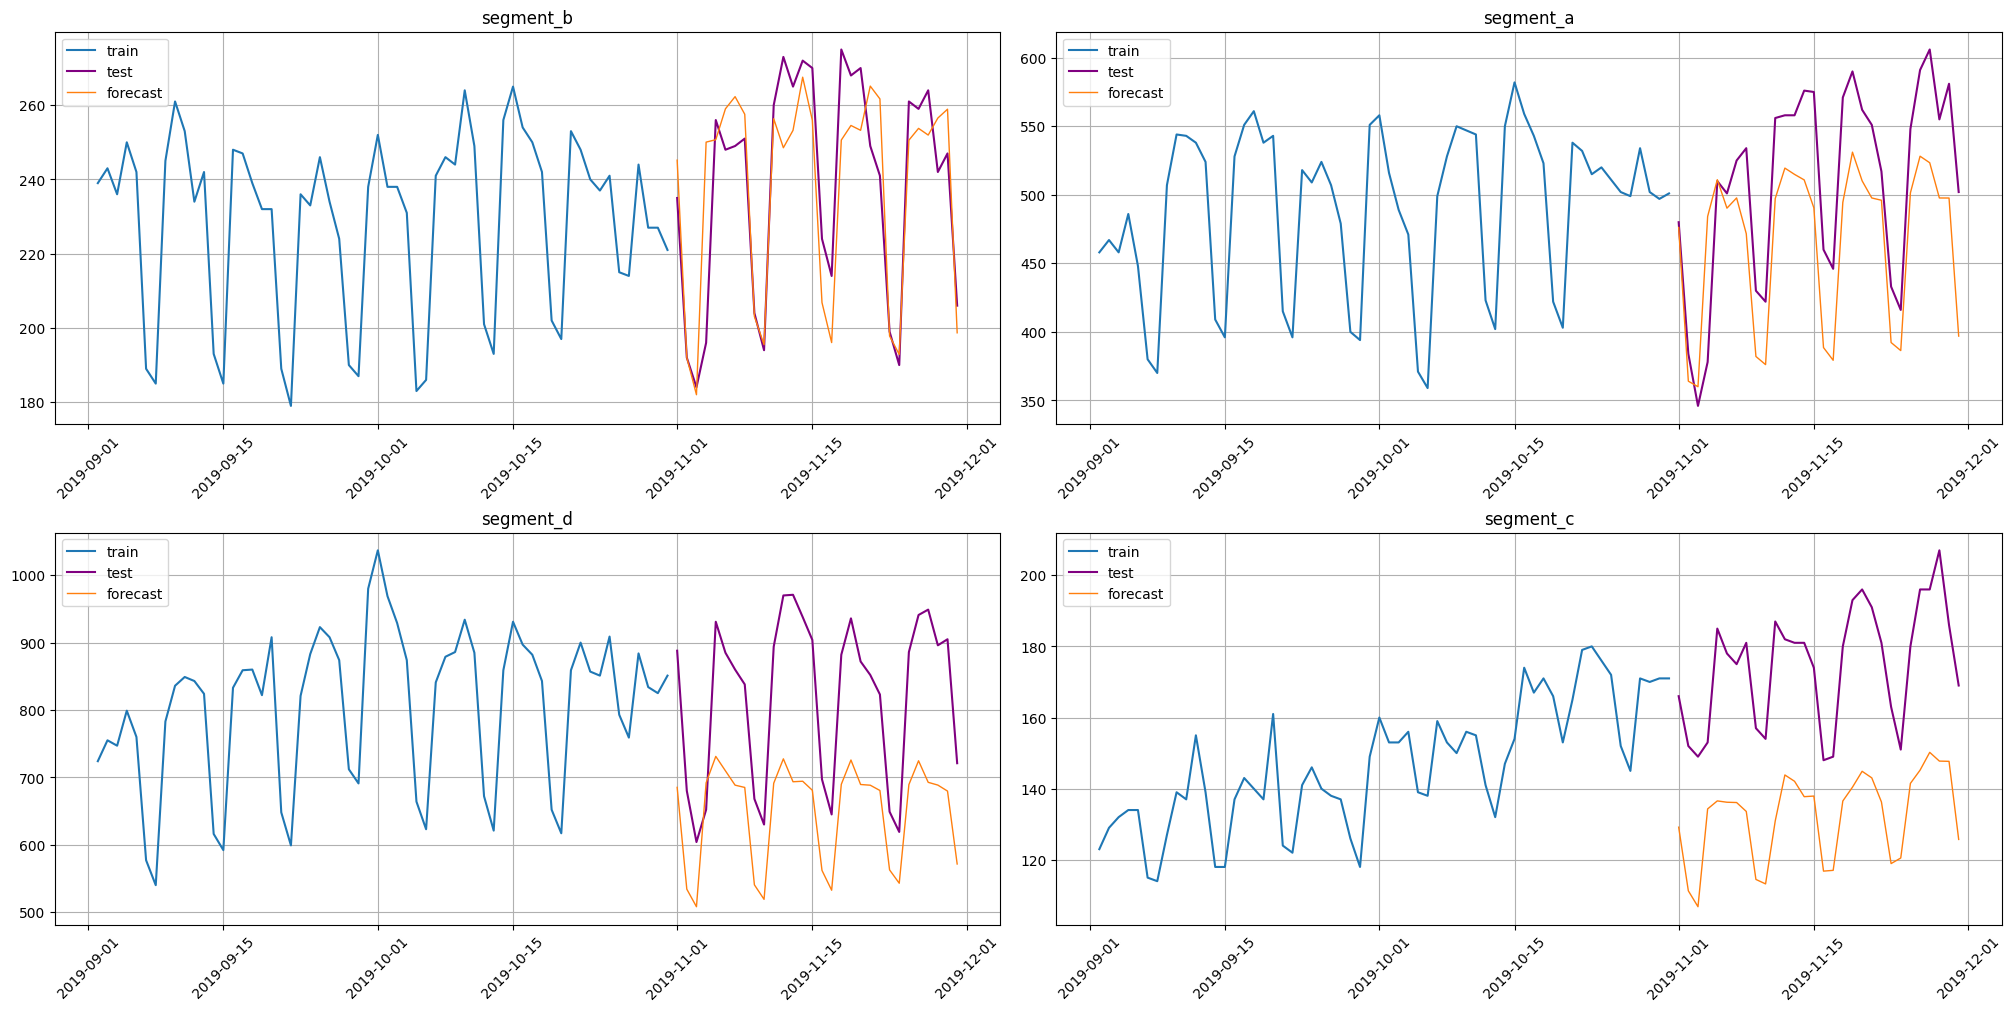

In [12]:
from etna.analysis import plot_forecast

plot_forecast(forecast_ts=forecast_ts, test_ts=test_ts, train_ts=new_ts, n_train_samples=HORIZON * 2)

In [13]:
from etna.metrics import SMAPE

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'segment_b': 4.881004133142118,
 'segment_a': 10.532267703711948,
 'segment_d': 22.951810829932462,
 'segment_c': 27.38832043668145}

Let's compare it with metrics of pipeline that was fitted on `new_ts`.

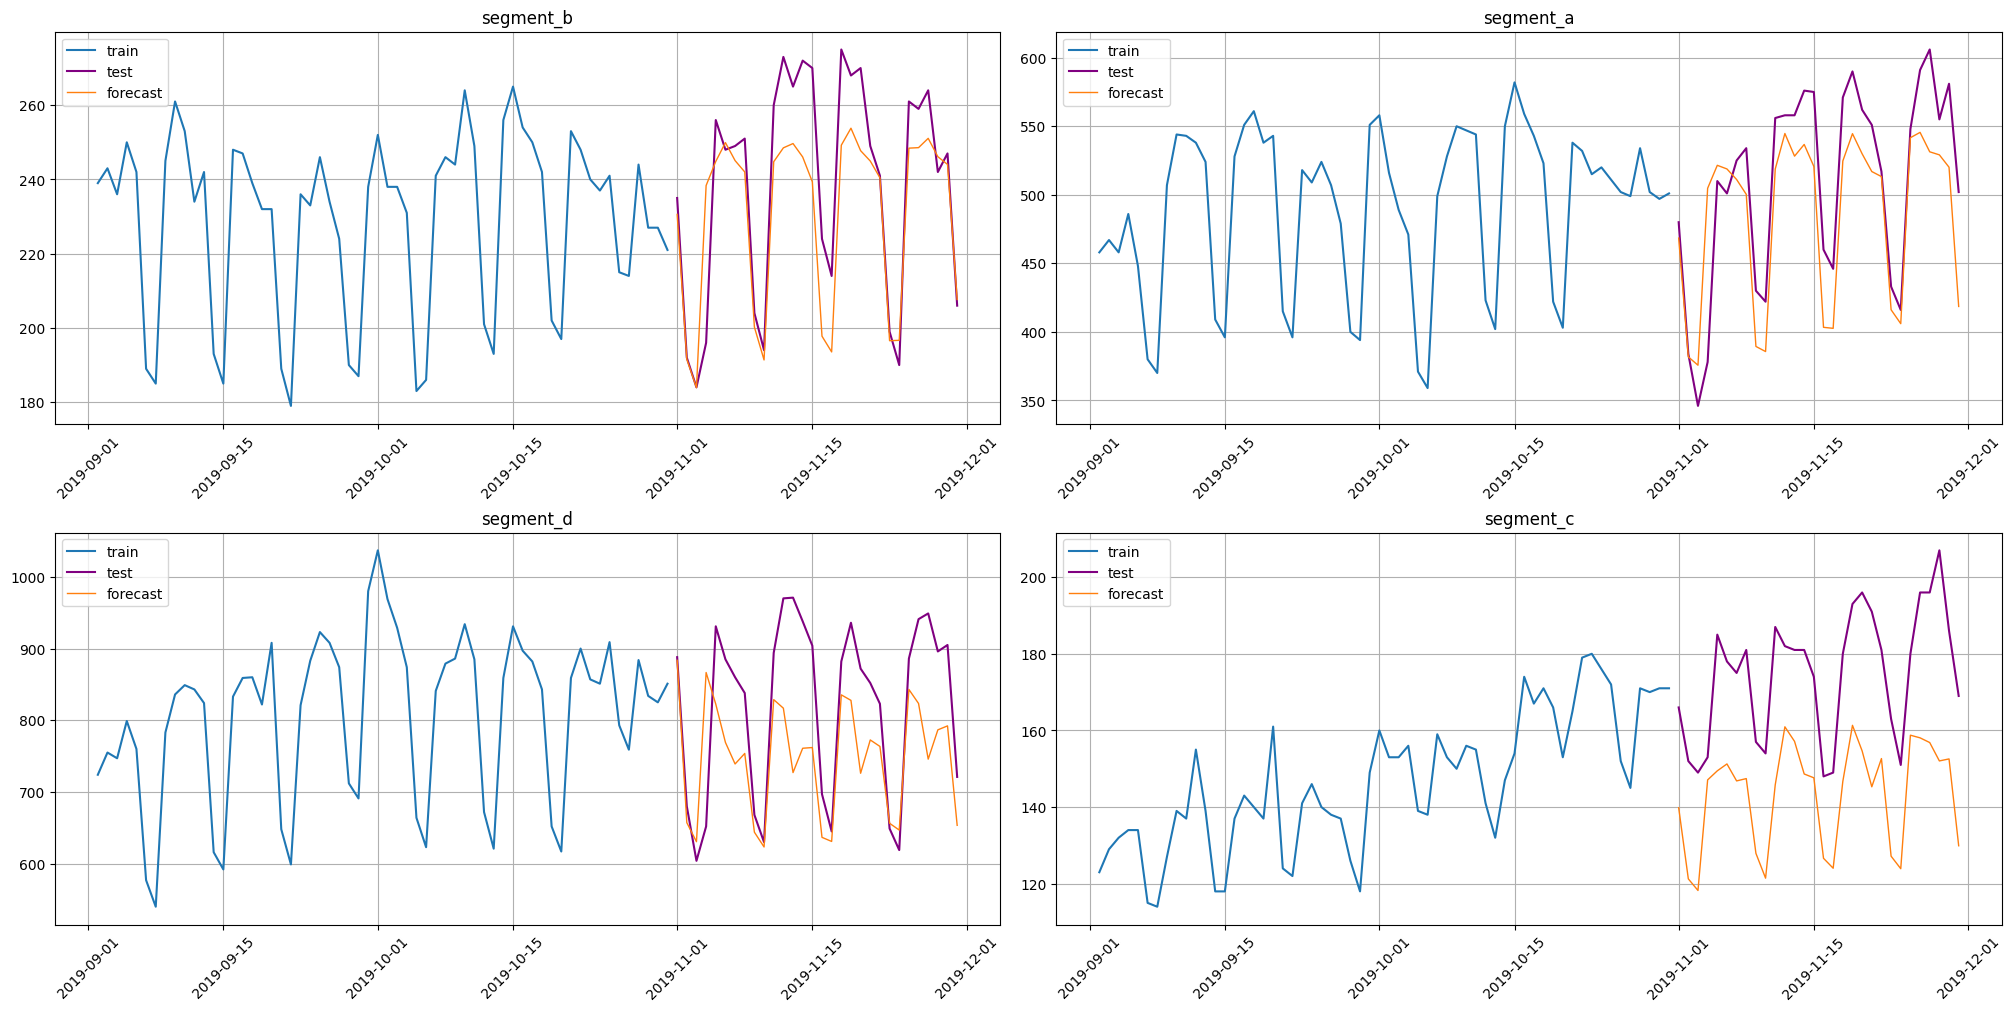

In [14]:
pipeline.fit(new_ts)
forecast_new_ts = pipeline.forecast()

plot_forecast(forecast_ts=forecast_new_ts, test_ts=test_ts, train_ts=new_ts, n_train_samples=HORIZON * 2)

In [15]:
smape(y_true=test_ts, y_pred=forecast_new_ts)

{'segment_b': 4.982914880262237,
 'segment_a': 7.3693082812947495,
 'segment_d': 11.10087090114358,
 'segment_c': 19.6708507179845}

As we can see, these predictions are better.